In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import load_nyt_database, word_freq, GetTemporalNIH, GetTemporalNSF, GetTemporalPsyc, IsValidYear
import itertools
from matplotlib.ticker import ScalarFormatter, LogFormatterMathtext

In [2]:
%matplotlib inline

In [3]:
nyt = load_nyt_database()
psyc = GetTemporalPsyc()
nih = GetTemporalNIH()
nsf = GetTemporalNSF()
all_words = set(nsf.columns.tolist() + nih.columns.tolist() + psyc.columns.tolist() + nyt.columns.tolist())
words = [x for x in all_words if x!= "Total"]
books = word_freq(words)
books.rename(columns={k:k.strip() for k in books.columns}, inplace=True)

In [4]:
cultural_groups = {'bi': ['bicultural', 'biracial', 'biethnic', 'interracial'],
 'mixed': ['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity'],
 'mono': ['monoracial', 'monoethnic', 'monocultural'],
 'multi': ['multiethnic', 'multicultural', 'multiracial', 'polycultural', 'polyethnic', 'polyracial'],
 'theory': ['multiculturalism', 'cultural pluralism', 'polyculturalism']}

In [5]:
for source, data in {"Books": books, "NYT": nyt, "Psyc":psyc, "NIH": nih, "NSF": nsf}.items():
  for k, v in cultural_groups.items():
    v = [v_ for v_ in v if v_ in data]
    data[k] = data[v].fillna(0).sum(axis=1)
    words.append(k)
words = set(words)

In [13]:
def plot_all(words, norm=True):
    df1 = books[words]
    y = df1
    if norm:
     y = y / y.mean()
    axis_1 = y.plot(figsize=(24,6))
    axis_1.set_title("Google Book Ngrams", fontsize=24)
    axis_1.set_xlabel("Year")
    _ = axis_1.legend(loc='upper left', ncol=2)
    axis_1.set_yscale('log') # You can disable
    if norm:
      axis_1.set_ylim(1e-2, 1e2) # You can disable
    axis_1.yaxis.set_major_formatter(LogFormatterMathtext())     
    axis_1.grid(True)
    axis_1.set_xlim(xmin=1800)
    axis_1.set_xlabel("Year", fontsize=20)
    axis_1.set_ylabel("Percentage of historical average", fontsize=20)

    y = pd.rolling_apply(nyt[words], window=10, func=np.mean, center=False)
    if norm:
     y = y/ y.mean()
    axis_2 = y.plot(figsize=(24,6))
    axis_2.set_title("New York Times", fontsize=24)
    axis_2.set_yscale('log') # You can disable
    axis_2.set_ylabel("Percentage of historical average", fontsize=20)
    axis_2.set_xlabel("Year", fontsize=20)
    if norm:
      axis_2.set_ylim(1e-2, 1e2) # You can disable
    else:
      axis_2.set_ylim(ymin=1e-7) # You can disable        
    axis_2.yaxis.set_major_formatter(LogFormatterMathtext())
    axis_2.grid(True)
    axis_2.set_xlim(xmin=1800)
    _ = axis_2.legend(loc='upper left', ncol=2)
    
    for title, data in {"Psyc Info Metadata":psyc, "NIH Grants": nih, "NSF Grants": nsf}.items():
        y = data[words]
        y = pd.rolling_apply(y, window=3, func=np.mean, center=False)
        if norm:
          y = y / y.mean()
        axis = y.plot(figsize=(24,6))
        axis.set_title(title, fontsize=24)
        axis.set_xlabel("Year", fontsize=20)
        axis.set_ylabel("Percentage of historical average", fontsize=20)
        #axis_3.set_yscale('log') # You can disable    
        axis.set_xlim(xmin=1850)
        axis.grid(True)
        _ = axis.legend(loc='upper left', ncol=2)
        

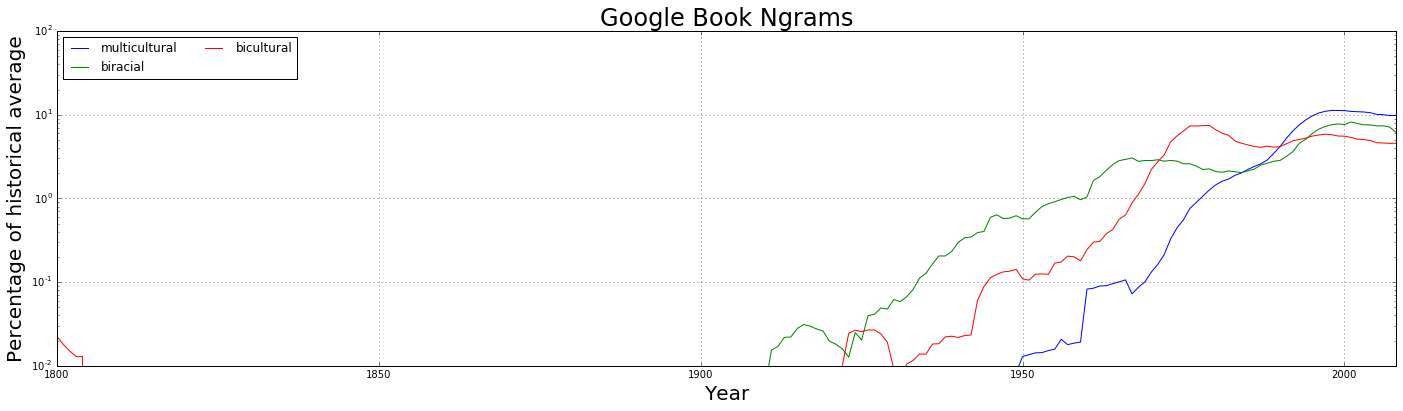

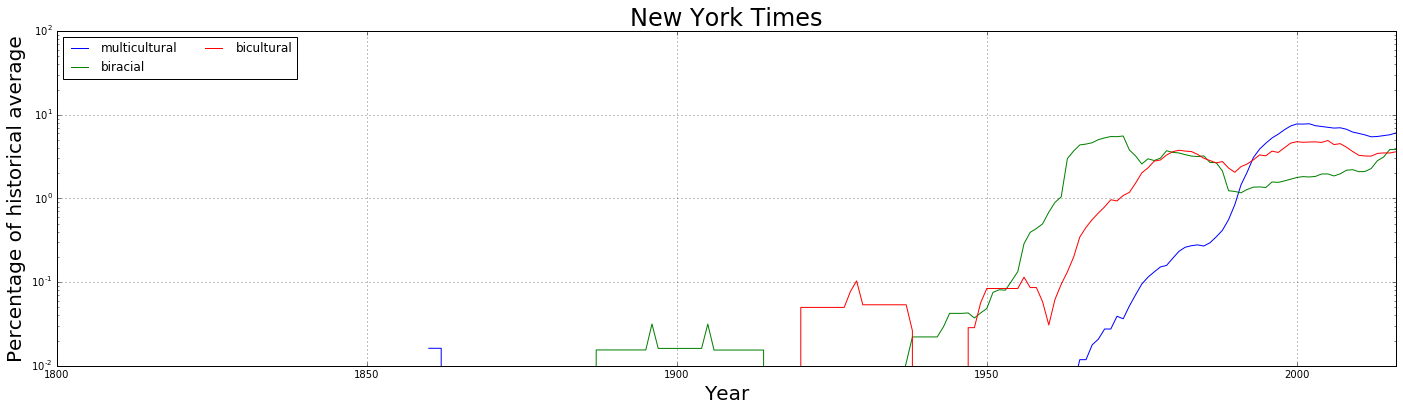

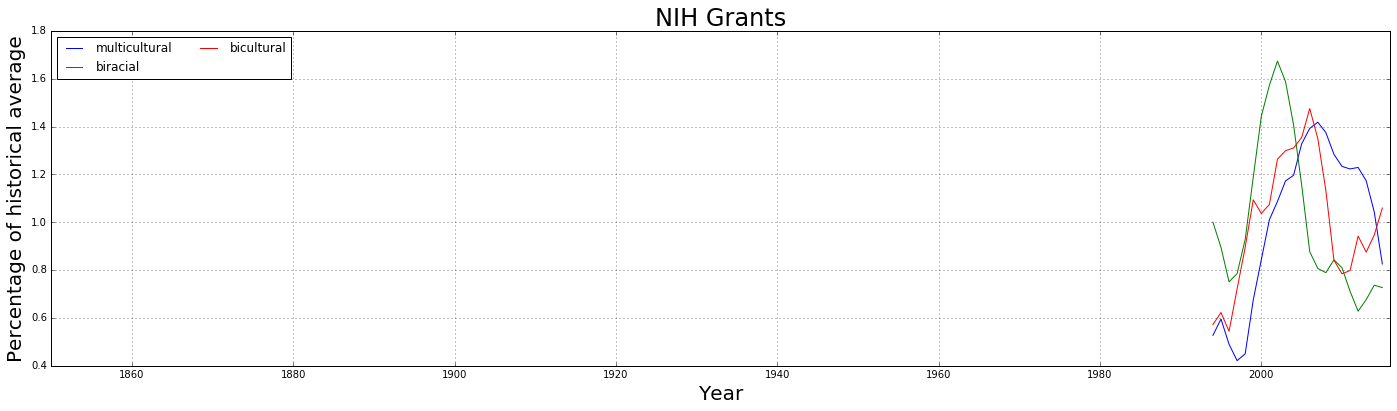

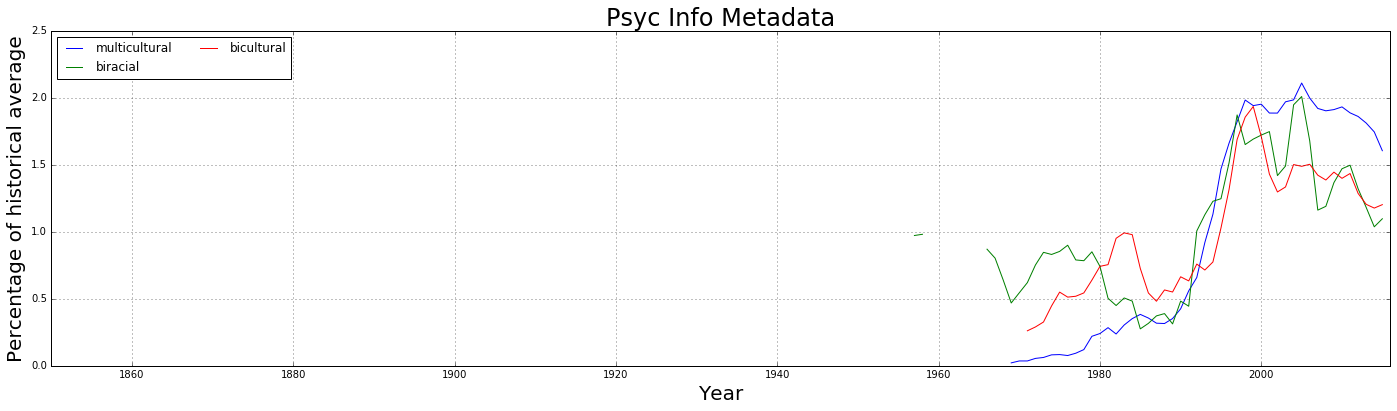

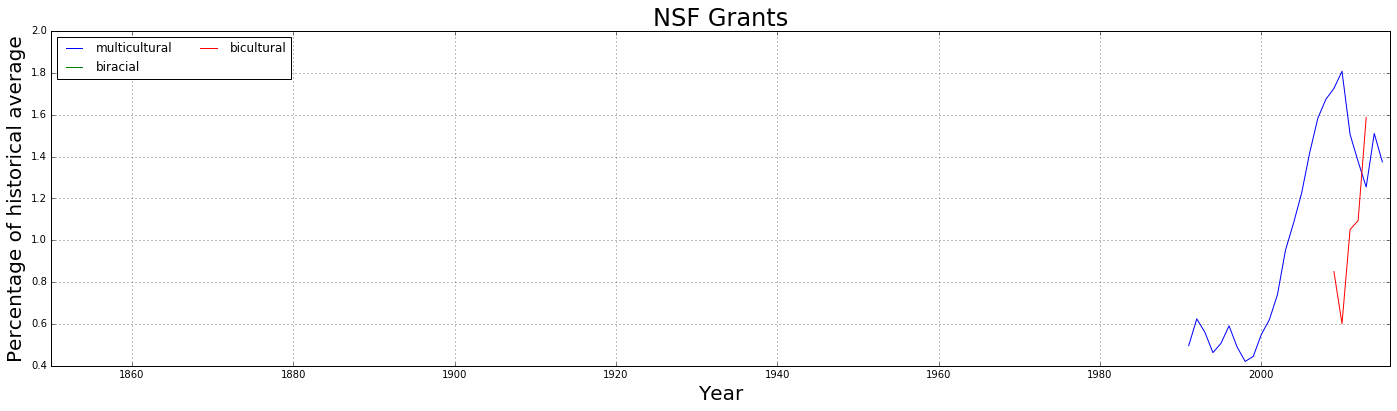

In [14]:
sample = ["multicultural", "biracial", "bicultural"]
plot_all(sample)

In [15]:
def StatsFromSeries(y):
    historical_avg = y.mean()
    #plt.plot(y.index, historical_avg)
    years1 = y[y > 0].index
    years2 = y[y > historical_avg].index
    years1 = np.nan if not len(years1) else int(years1[0]) 
    years2 = np.nan if not len(years2) else int(years2[0]) 
    record = {"First Appearance": years1,
              "Passed Hist Avg": years2,
              "Historical Avg": historical_avg
              }
    return record

In [18]:
records = []

for source, data in {"Books": books, "NYT": nyt, "Psyc":psyc, "NIH": nih, "NSF": nsf}.items():
    for word in words:
      window = 5 if source not in {"NYT"} else 10
      if word not in data:
        print("{} is not found in {}".format(word, source))
        continue
      if source != "Books":
        y = pd.rolling_apply(data[word], window=window, func=np.mean, center=False)
      else:
        y = data[word]
      record = StatsFromSeries(y)
      record["Word"] = word
      record["Source"] = source
      records.append(record)
df = pd.DataFrame.from_dict(records)

polyracial is not found in Books
polyracial is not found in Psyc
polyethnic is not found in NIH
polyculturalism is not found in NIH
monoethnic is not found in NIH
polyracial is not found in NIH
polycultural is not found in NIH
polyethnic is not found in NSF
polyculturalism is not found in NSF
monoethnic is not found in NSF
monoracial is not found in NSF
polyracial is not found in NSF
biethnic is not found in NSF


In [19]:
df[df.Word == "multicultural"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
16,1804,6.119381e-07,1978,Books,multicultural
64,1860,2.745980e-04,1991,NYT,multicultural
40,1971,2.454069e-03,1995,Psyc,multicultural
86,1996,4.930978e-04,2003,NIH,multicultural
106,1993,1.525363e-03,2005,NSF,multicultural


In [20]:
df[df.Word == "biracial"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
20,1877,7.661761e-08,1957,Books,biracial
69,1887,1.132427e-04,1962,NYT,biracial
44,1968,2.256788e-04,1995,Psyc,biracial
89,1996,2.141674e-04,2000,NIH,biracial
109,NaN,NaN,NaN,NSF,biracial


In [21]:
df[df.Word == "mixed race"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
1,1800,2.292530e-07,1804,Books,mixed race
49,1860,1.454937e-04,1978,NYT,mixed race
25,1978,1.454176e-04,1996,Psyc,mixed race
74,2005,3.496893e-05,2012,NIH,mixed race
94,NaN,NaN,NaN,NSF,mixed race


In [22]:
df[df.Word == "monocultural"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
9,1897,2.722419e-08,1964,Books,monocultural
57,1963,3.010832e-06,1990,NYT,monocultural
33,1990,8.022883e-05,1999,Psyc,monocultural
99,1992,2.468649e-04,2003,NSF,monocultural
79,2004,2.009645e-05,2004,NIH,monocultural


In [23]:
df[df.Word == "monoracial"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
65,1967,2.120028e-07,1967,NYT,monoracial
17,1890,3.852619e-09,1985,Books,monoracial
41,1996,4.849260e-05,2009,Psyc,monoracial
87,NaN,NaN,NaN,NIH,monoracial


In [24]:
df[df.Word == "monoethnic"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
6,1902,2.452068e-09,1973,Books,monoethnic
54,1993,1.298237e-06,1993,NYT,monoethnic
30,2015,1.573030e-05,NaN,Psyc,monoethnic


## Cultural Groups

In [25]:
df[df.Word == "mono"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
11,1890,3.352888e-08,1965,Books,mono
35,1969,4.483880e-05,1981,Psyc,mono
59,1963,4.521072e-06,1990,NYT,mono
101,1988,1.259989e-04,1992,NSF,mono
81,2000,6.554667e-06,2001,NIH,mono


In [26]:
df[df.Word == "bi"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
38,1916,1.015473e-03,1916,Psyc,bi
14,1800,7.591945e-07,1934,Books,bi
62,1887,5.394307e-04,1950,NYT,bi
104,1971,2.408287e-04,1971,NSF,bi
84,1996,4.029089e-04,2000,NIH,bi


In [27]:
df[df.Word == "mixed"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
4,1800,4.692801e-07,1819,Books,mixed
52,1860,2.996107e-04,1868,NYT,mixed
28,1916,2.040726e-04,1916,Psyc,mixed
95,1970,6.130648e-03,1970,NSF,mixed
75,1996,1.107567e-04,2011,NIH,mixed


In [28]:
df[df.Word == "multi"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
15,1804,8.528545e-07,1975,Books,multi
63,1860,5.385239e-04,1976,NYT,multi
39,1946,1.559926e-03,1993,Psyc,multi
105,1972,1.279028e-03,1999,NSF,multi
85,1996,1.392761e-03,2003,NIH,multi


In [29]:
df[df.Word == "theory"].sort_values(by="Passed Hist Avg")

,First Appearance,Historical Avg,Passed Hist Avg,Source,Word
7,1804,3.536403e-07,1971,Books,theory
55,1924,9.892791e-05,1991,NYT,theory
31,1940,7.189796e-04,1996,Psyc,theory
97,1991,7.009721e-05,1997,NSF,theory
77,1996,1.762699e-04,2008,NIH,theory


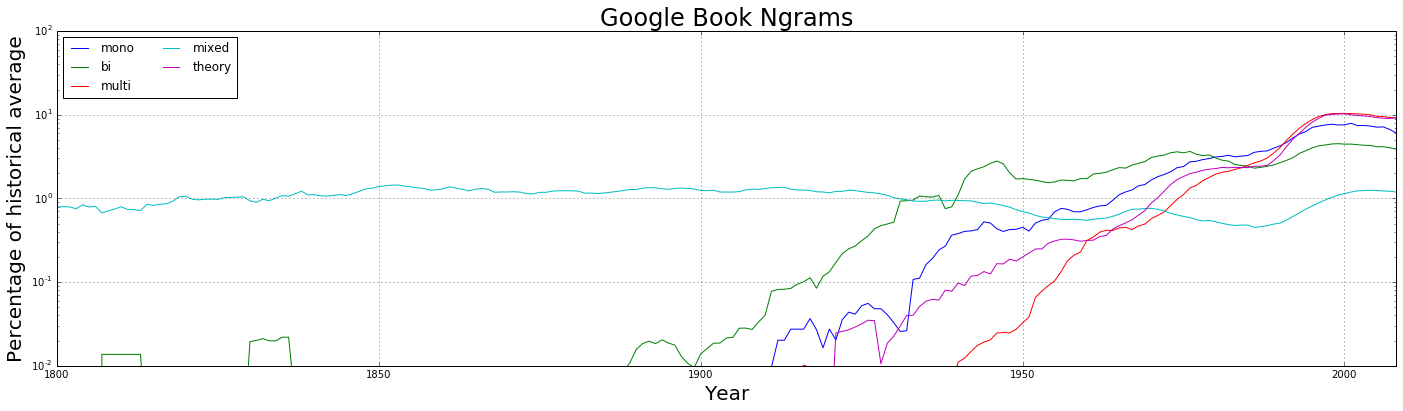

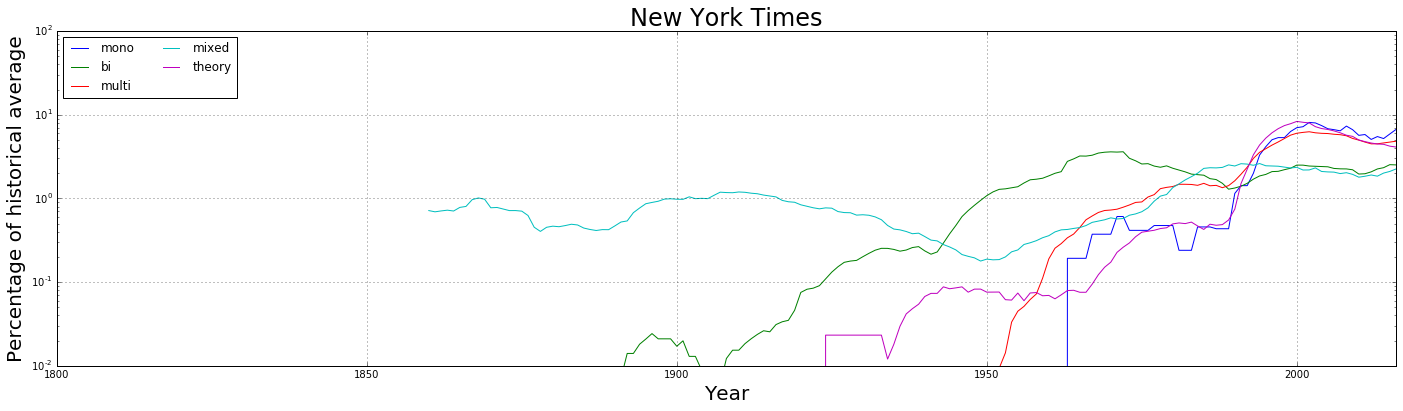

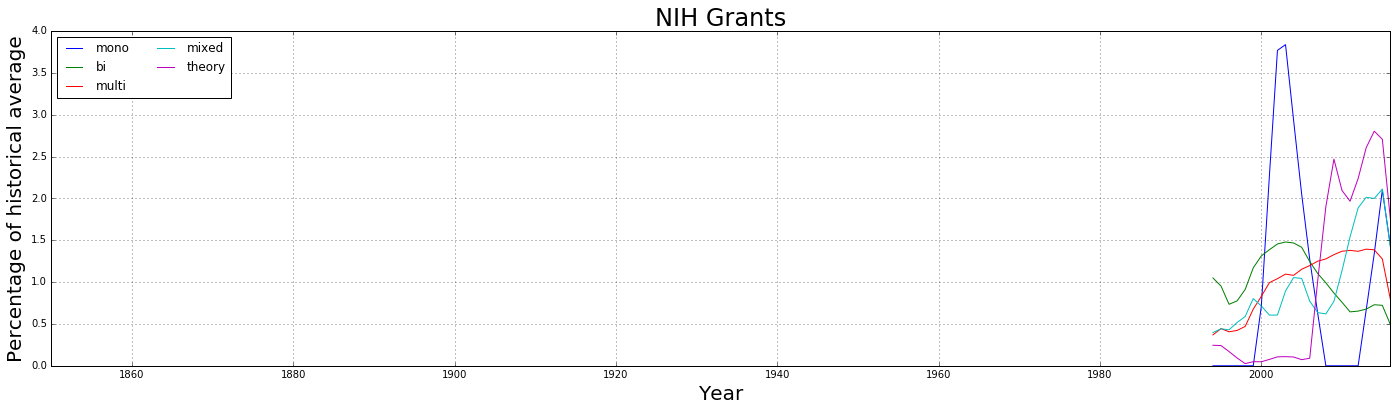

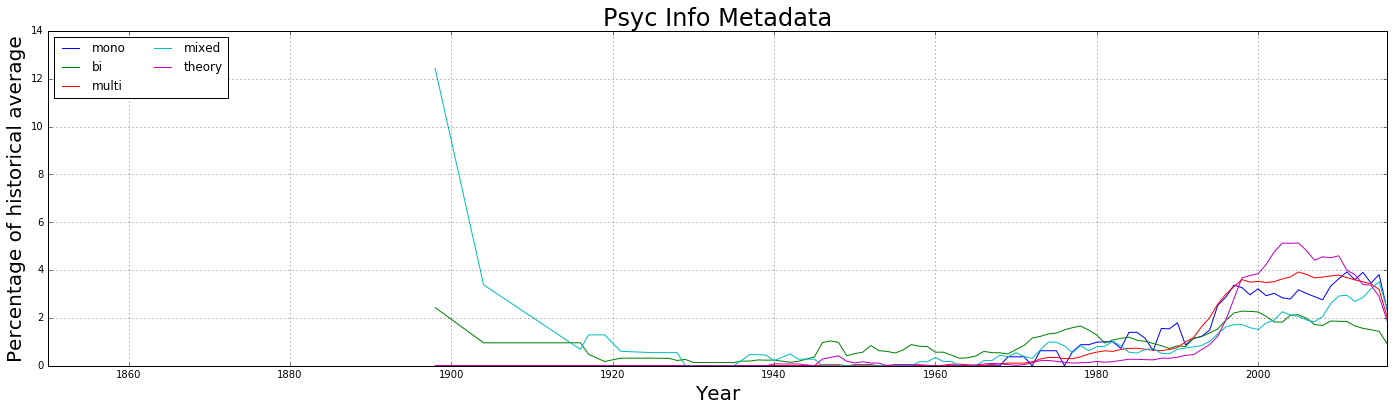

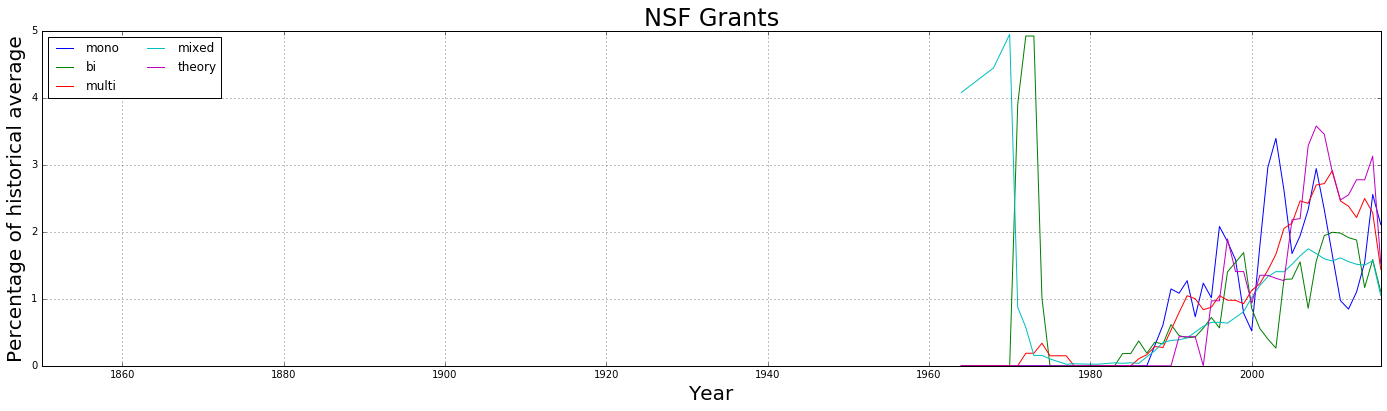

In [30]:
sample = ["mono", "bi", "multi", "mixed", "theory"]
plot_all(sample)

In [33]:
foo = psyc[psyc.index == 1850]
foo.values[foo.notnull().values]

array([ 0.0060241,  0.0060241,  0.0060241,  0.0060241,  0.       ,
        0.       ,  0.       ])

In [34]:
from tools import get_psycinfo_database
psycinfo = get_psycinfo_database()
total_pub = pd.DataFrame.from_csv("data/PsycInfo/PsycInfo Articles Review.csv")
total_pub["Year"] = [int(x) for x in total_pub.index.year]
total_pub.set_index("Year", inplace=True)
total_pub.rename(columns={"Articles": "Publications_Count"}, inplace=True)
clean_psycinfo = psycinfo[[IsValidYear(x) for x in psycinfo.Date.values]]
clean_psycinfo = clean_psycinfo.copy()
clean_psycinfo["Year"] = [int(x) for x in clean_psycinfo.Date]
clean_psycinfo["value"] = 1 
temporal_psyc = clean_psycinfo.pivot_table(index="Year", columns=["Term"], values="value", aggfunc=np.sum)
#total_counts = total_pub.loc[temporal_psyc.index]
#temporal_psyc.loc[temporal_psyc.index] = (temporal_psyc.values.T / total_counts.values.flatten()).T

